In [50]:
%pip install wandb
%pip install graphviz
%pip install torchviz
import wandb
wandb.login()#doesnt detect WANDB_NOTEBOOK_NAME on windows


Note: you may need to restart the kernel to use updated packages.


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Note: you may need to restart the kernel to use updated packages.


True

In [51]:
wandb.init(project="test-project", entity="simclr-doctoral-research")

loss,▁▁▁▁▁▁▁▁▁▁██▇▇██▇▇▇▇
loss,1.45684


In [52]:
wandb.config = {
  "learning_rate": 0.001,
  "epochs": 10,
  "batch_size": 512
}
image_size = 32
image_depth = 3

In [53]:
import os
import wandb
import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST,CIFAR10
from torchvision.utils import save_image

if not os.path.exists('./mlp_img'):
    os.mkdir('./mlp_img')


def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    x = x.view(x.size(0), image_depth, image_size, image_size)
    return x


num_epochs = 50
batch_size = 512
learning_rate = 1e-3

img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# dataset_train = MNIST('./data', transform=img_transform, download=True,train = True)
# dataset_test = MNIST('./data', transform=img_transform, download=True,train = False)
dataset_train = CIFAR10('./data', transform=img_transform, download=True,train = True)
dataset_test = CIFAR10('./data', transform=img_transform, download=True,train = False)

dataloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)


class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(image_size * image_size*image_depth, 256),
            nn.ReLU(True),
            nn.Linear(256, 128))
        self.decoder = nn.Sequential(
            nn.Linear(128, 256),
            nn.ReLU(True),
            nn.Linear(256,image_size * image_size*image_depth), 
            nn.Tanh())
    def forward(self, x,only_encode=False):
        if only_encode:
            return self.encoder(x)
        x = self.encoder(x)
        x = self.decoder(x)
        return x



Files already downloaded and verified
Files already downloaded and verified


In [55]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(str(device)+"Is being used")
auto_model = AutoEncoder().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, auto_model.parameters()), lr=learning_rate, weight_decay=1e-5)#this line is needed
#to freeze gradients

for epoch in range(num_epochs):
    for data in dataloader:
        img, _ = data
        img = img.view(img.size(0), -1)
        img = Variable(img).to(device)
        # ===================forward=====================
        output = auto_model(img)
        loss = criterion(output, img)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch + 1, num_epochs, loss.item()))
    if epoch % 10 == 0:
        pic = to_img(output.cpu().data)
        save_image(pic, './mlp_img/image_{}.png'.format(epoch))
    wandb.log({"loss": loss})

    wandb.watch(auto_model)
    #print('epoch [{}/{}], loss:{:.4f}'.format(epoch + 1, num_epochs, loss.data[0]))

pic = to_img(output.cpu().data)
save_image(pic, './mlp_img/image_final.png')


cudaIs being used
epoch [1/50], loss:0.0591
epoch [2/50], loss:0.0469
epoch [3/50], loss:0.0432
epoch [4/50], loss:0.0405
epoch [5/50], loss:0.0373
epoch [6/50], loss:0.0359
epoch [7/50], loss:0.0335
epoch [8/50], loss:0.0338
epoch [9/50], loss:0.0311
epoch [10/50], loss:0.0309
epoch [11/50], loss:0.0310
epoch [12/50], loss:0.0299
epoch [13/50], loss:0.0295
epoch [14/50], loss:0.0284
epoch [15/50], loss:0.0292
epoch [16/50], loss:0.0275
epoch [17/50], loss:0.0265
epoch [18/50], loss:0.0284
epoch [19/50], loss:0.0292
epoch [20/50], loss:0.0261
epoch [21/50], loss:0.0266
epoch [22/50], loss:0.0268
epoch [23/50], loss:0.0257
epoch [24/50], loss:0.0267
epoch [25/50], loss:0.0267
epoch [26/50], loss:0.0257
epoch [27/50], loss:0.0251
epoch [28/50], loss:0.0277
epoch [29/50], loss:0.0267
epoch [30/50], loss:0.0264
epoch [31/50], loss:0.0261
epoch [32/50], loss:0.0261
epoch [33/50], loss:0.0262
epoch [34/50], loss:0.0264
epoch [35/50], loss:0.0271
epoch [36/50], loss:0.0266
epoch [37/50], loss

In [56]:
#test of the model
test_data = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)

for data in test_data:
    img, _ = data
    img = img.view(img.size(0), -1)
    img = Variable(img).to(device)
    output = auto_model(img)
    pic = to_img(output.cpu().data)
    save_image(pic, './mlp_img/image_test.png')
#accuracy of the autoencoder comparing input and output
loss_sum = 0
for data in test_data:
    img, _ = data
    img = img.view(img.size(0), -1)
    img = Variable(img).to(device)
    output = auto_model(img)
    loss = criterion(output, img)
    loss_sum += loss.item()

print(loss_sum/len(test_data))


0.025820902548730373


In [57]:
from torchviz import make_dot
y = auto_model(img)
make_dot(y, params=dict(list(auto_model.named_parameters()))).render("torchviz", format="png")

'torchviz.png'

Now the encoder is going to be frozen

In [58]:
#freeze the encoder
# print(model.state_dict())

auto_model.encoder[0].weight.requires_grad = False
auto_model.encoder[0].bias.requires_grad = False
auto_model.encoder[2].weight.requires_grad = False
auto_model.encoder[2].bias.requires_grad = False


for name, param in auto_model.named_parameters():
    print(name, param.requires_grad)



# if param.requires_grad:print(name)
# for param in model.parameters():
#     print(param)
#     param.requires_grad = False


encoder.0.weight False
encoder.0.bias False
encoder.2.weight False
encoder.2.bias False
decoder.0.weight True
decoder.0.bias True
decoder.2.weight True
decoder.2.bias True


In [59]:
#save the encoder
os.makedirs('./saved_models', exist_ok=True)
torch.save(auto_model.state_dict(), './saved_models/autoencoder.pth')

In [60]:
from linear_classifier import LinearClassifier

In [61]:
# #load the encoder
# model.load_state_dict(torch.load('./saved_models/autoencoder.pth'))
# #add a mlp to the encoder
# model.add_module('linear_classifier', linear_classifier())



In [62]:
#joined model
class JoinedModel(nn.Module):
    def __init__(self):
        super(JoinedModel, self).__init__()
        self.encoder = auto_model.encoder
        self.classifier = LinearClassifier()
    def forward(self, x):
        x = self.encoder(x)
        x = self.classifier(x)
        return x
joined_model = JoinedModel().to(device)

In [63]:
joined_model.encoder[0].weight.requires_grad = False
joined_model.encoder[0].bias.requires_grad = False
joined_model.encoder[2].weight.requires_grad = False
joined_model.encoder[2].bias.requires_grad = False

In [64]:
#verify weight are frozen

for name, param in joined_model.named_parameters():
    print(name, param.requires_grad)
print(joined_model.parameters)


encoder.0.weight False
encoder.0.bias False
encoder.2.weight False
encoder.2.bias False
classifier.fc1.weight True
classifier.fc1.bias True
classifier.fc2.weight True
classifier.fc2.bias True
<bound method Module.parameters of JoinedModel(
  (encoder): Sequential(
    (0): Linear(in_features=3072, out_features=256, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=256, out_features=128, bias=True)
  )
  (classifier): LinearClassifier(
    (fc1): Linear(in_features=128, out_features=128, bias=True)
    (relu): ReLU()
    (fc2): Linear(in_features=128, out_features=10, bias=True)
  )
)>


In [65]:
#train the model on the labeled data
# model = model.to(device)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, joined_model.parameters()), lr=learning_rate, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()
for epoch in range(num_epochs):
    for data in dataloader:
        img, label = data
        img = img.view(img.size(0), -1)
        img = Variable(img).to(device)
        label = Variable(label).to(device)
        # ===================forward=====================
        output = joined_model(img)#This should only use the encoder
        loss = criterion(output, label)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    print('epoch [{}/{}], loss:{:.4f}'
            .format(epoch + 1, num_epochs, loss.item()))
    wandb.log({"loss": loss})
    wandb.watch(joined_model)

epoch [1/50], loss:1.7488
epoch [2/50], loss:1.5887
epoch [3/50], loss:1.5546
epoch [4/50], loss:1.4336
epoch [5/50], loss:1.4494
epoch [6/50], loss:1.4212
epoch [7/50], loss:1.4220
epoch [8/50], loss:1.3651
epoch [9/50], loss:1.3006
epoch [10/50], loss:1.2074
epoch [11/50], loss:1.2599
epoch [12/50], loss:1.3049
epoch [13/50], loss:1.2151
epoch [14/50], loss:1.3078
epoch [15/50], loss:1.2700
epoch [16/50], loss:1.2386
epoch [17/50], loss:1.2434
epoch [18/50], loss:1.3793
epoch [19/50], loss:1.2426
epoch [20/50], loss:1.2328
epoch [21/50], loss:1.2406
epoch [22/50], loss:1.1328
epoch [23/50], loss:1.2531
epoch [24/50], loss:1.1403
epoch [25/50], loss:1.1254
epoch [26/50], loss:1.2284
epoch [27/50], loss:1.0914
epoch [28/50], loss:1.2306
epoch [29/50], loss:1.1427
epoch [30/50], loss:1.0832
epoch [31/50], loss:1.1075
epoch [32/50], loss:1.1120
epoch [33/50], loss:1.2275
epoch [34/50], loss:1.1196
epoch [35/50], loss:1.1206
epoch [36/50], loss:1.1381
epoch [37/50], loss:1.1505
epoch [38/

In [66]:
#evaluate the model
loss_sum = 0
test_data = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)
for data in test_data:
    img, label = data
    img = img.view(img.size(0), -1)
    img = Variable(img).to(device)
    label = Variable(label).to(device)
    output = joined_model(img)
    loss = criterion(output, label)
    loss_sum += loss.item()


print(loss_sum/len(test_data))


1.3498326361179351


In [67]:
#

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


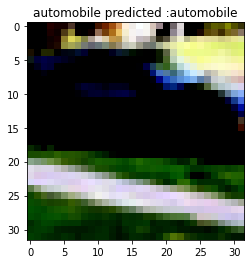

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


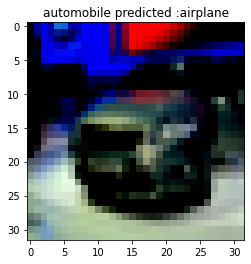

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


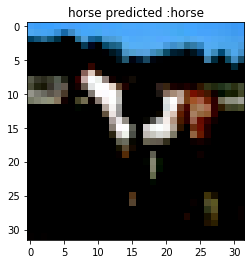

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


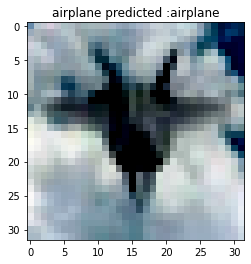

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


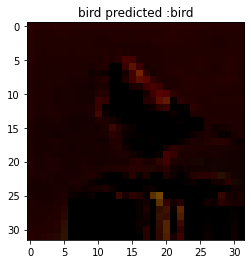

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


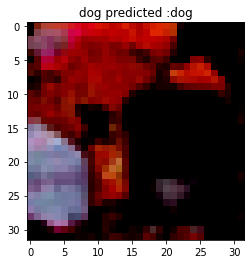

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


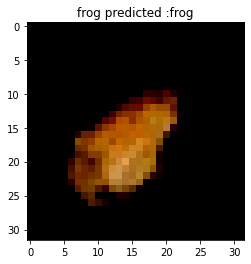

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


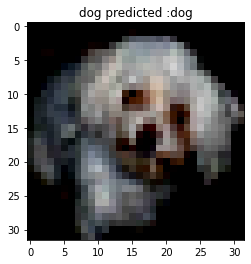

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


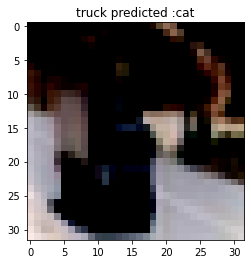

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


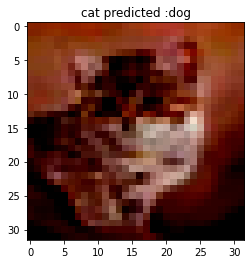

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


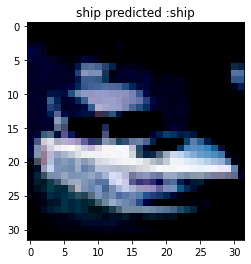

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


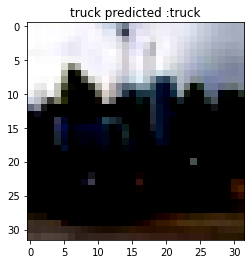

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


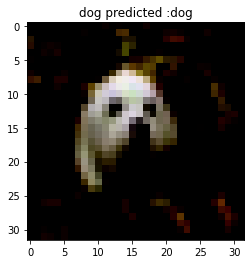

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


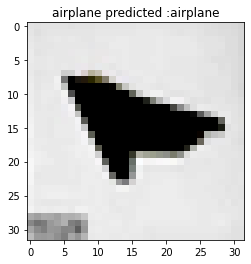

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


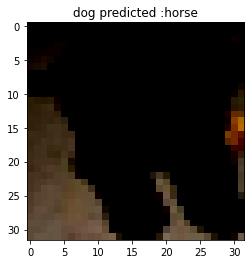

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


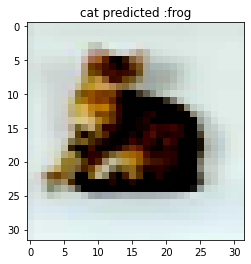

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


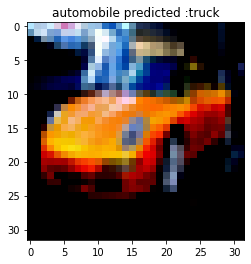

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


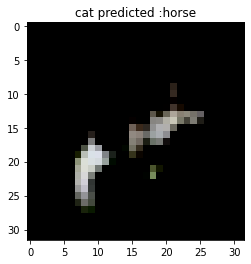

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


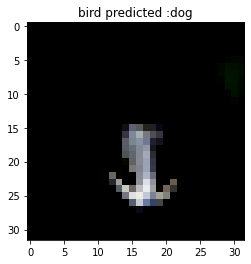

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


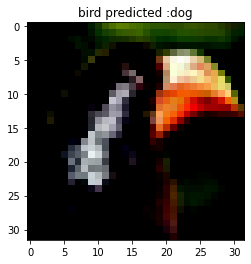

In [68]:
import matplotlib.pyplot as plt
import numpy as np
# from fastai.vision.all import show_image
#show results of the model
test_data = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)
for data in test_data:
    img, label = data
    img = img.view(img.size(0), -1)
    img = Variable(img).to(device)
    #label = Variable(label).to(device)
    output = joined_model(img)
    pic = to_img(img.cpu().data)
    # save_image(pic, './mlp_img/image_test.png')
    #show predicted label for the image
    #print(output.argmax(dim=1))
    #show the true label for the image
    #print(label)
    #show the image
    plt.imshow(np.transpose(img.view(img.size(0), image_depth, image_size, image_size).cpu().data[0], (1,2, 0)))
    #show the label corresponding to the image
    #print class name

    plt.title(dataset_test.classes[label.cpu().data[0]]+" predicted :"+ dataset_test.classes[output.argmax(dim=1)[0]])
    plt.show()
    plt.close()

    

In [69]:
# evaluate model:
joined_model.eval()

with torch.no_grad():
    correct = 0
    total = 0
    for data in test_data:
        img, label = data
        img = img.view(img.size(0), -1)
        img = Variable(img).to(device)
        label = Variable(label).to(device)
        output = joined_model(img)
        _, predicted = torch.max(output.data, 1)
        total += label.size(0)
        correct += (predicted == label).sum().item()
    print("accuracy: ", correct/total)

        

accuracy:  0.5331


In [70]:
#save the joined_model
torch.save(joined_model.state_dict(), './saved_models/joined_model.pth')
